# Benchmark for vibration of a string

Assumptions made:
- string is treated as perfectly flexible (no stiffness)
- fixed-fixed condition so that reflections are perfectly inverted

Goal: simulate the kink resulting from plucking the string

Constituitive equation (wave equation): $\frac{\partial^2 y}{\partial t^2} = c^2 \frac{\partial^2 y}{\partial x^2}$

where,
$
y = displacement\:of\:the\:string\:from\:equilibirum \\
x = position\:along\:the\:string \\
t = time \\
c = \sqrt{\frac{T}{\mu}} = wave\:speed \\
T = tension \\
\mu = mass\:per\:unit\:length \\
$

Citation(s):
$@article\:{giordano1998physics,
  title={The physics of vibrating strings},
  author={Giordano, Nicholas and Gould, Harvey and Tobochnik, Jan}, 
  journal={Computers in Physics}, 
  volume={12},
  number={2}, 
  pages={138--145}, 
  year={1998},
  publisher={American Institute of Physics}
}$

In [2]:
using CombinatorialSpaces, DifferentialEquations, CairoMakie
using Catlab.CategoricalAlgebra
using Plots

# dual subdivision 
function dual(s::EmbeddedDeltaSet1D{O, P}) where {O, P}
  sd = EmbeddedDeltaDualComplex1D{O, eltype(P), P}(s)
  subdivide_duals!(sd, Circumcenter())
  sd
end

dual (generic function with 1 method)

## Define and plot mesh and boundary conditions

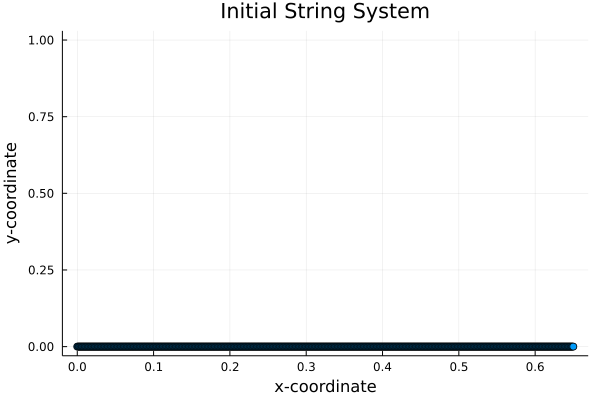

In [3]:
# Define mesh
s2D = EmbeddedDeltaSet2D("meshes/truss.obj")
s = EmbeddedDeltaSet1D{Bool, eltype(s2D[:point])}()

add_vertices!(s, 650, point=[eltype(s2D[:point])(i,0.0,0.0) for i in range(0, 0.650, length=650)])
add_edges!(s, [i for i in 1:(nv(s)-1)], [i+1 for i in 1:(nv(s)-1)], edge_orientation=true)
orient!(s) # for laplacian

sd = dual(s)

# Define vertices for BC application (fixed-fixed)
left = 1
right = nv(s)

# Plot mesh
x_loc = [p[1] for p in s[:point]]
y_loc = [p[2] for p in s[:point]]
Plots.plot(x_loc, y_loc,
     legend=:none, seriestype = :scatter,
     xlabel="x-coordinate",ylabel="y-coordinate",
     title="Initial String System",
     ylims=[minimum(y_loc),0],
     xlims=[minimum(x_loc),maximum(x_loc)])

## Plot initial string pluck distribution

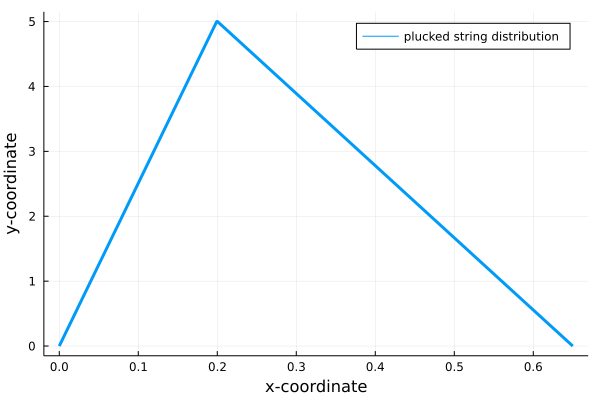

In [4]:
x = VForm([p[1] for p in s[:point]]); # x-location along string
y = VForm([p[2] for p in s[:point]]); # y-location 

y1 = collect(range(0.0, 5.0, length=200))
y2 = collect(range(5.0, 0.0, length=(length(x)-200)))

y = [y1; y2]

Plots.plot(x, y, 
     label = "plucked string distribution",
     xlabel="x-coordinate", ylabel="y-coordinate",
     linewidth = 3)


## Add the physics

In [5]:
c = 2 # wave speed, m/s
γ = -0.75 # damping factor, N*s/m

v = VForm(zeros(nv(s))) # y velocity

lapl = ∇²(Val{0}, sd) # initialize the laplace de-Rham operator

u0 = vcat(x.data, y, v.data) # initial condition for displacement

x_range = 1:length(x)
y_range = (1:length(y)) .+ length(x)
v_range = (1:length(v)) .+ length(x) .+ length(y)

# Physics WITHOUT damping
vf1(du, u, p, t) = begin
    du[v_range] .= (-1*p[1]^2) .* (lapl * u[y_range]) # wave equation
    du[y_range] .= u[v_range] # updates velocity
    du[y_range[left]] = 0.0
    du[y_range[right]] = 0.0
end

# Physics with damping
vf3(du, u, p, t) = begin
    du[v_range] .= (-1*p[1]^2) .* (lapl * u[y_range]) 
    du[y_range] .= u[v_range] 
    du[v_range] .+= p[2] .* u[v_range] # add damping
    du[y_range[left]] = 0.0
    du[y_range[right]] = 0.0
end


[0.0, 0.0010015408042818308, 0.0020030816085636616, 0.0030046224128454924, 0.004006163217127323, 0.005007704254239798, 0.006009244825690985, 0.007010785862803459, 0.008012326434254646, 0.009013867937028408, 0.010015408508479595, 0.011016949079930782, 0.01201848965138197, 0.013020031154155731, 0.014021571725606918, 0.015023112297058105, 0.016024652868509293, 0.01702619343996048, 0.018027735874056816, 0.019029276445508003, 0.02003081701695919, 0.021032357588410378, 0.022033898159861565, 0.023035438731312752, 0.02403697930276394, 0.025038519874215126, 0.026040062308311462, 0.02704160287976265, 0.028043143451213837, 0.029044684022665024, 0.03004622459411621, 0.031047765165567398, 0.032049305737018585, 0.03305084630846977, 0.03405238687992096, 0.03505392745137215, 0.03605547174811363, 0.03705701231956482, 0.038058552891016006, 0.039060093462467194, 0.04006163403391838, 0.04106317460536957, 0.042064715176820755, 0.04306625574827194, 0.04406779631972313, 0.045069336891174316, 0.04607087746262

, 0.5468413233757019, 0.5478428602218628, 0.5488443970680237, 0.5498459339141846, 0.5508474707603455, 0.5518490076065063, 0.5528505444526672, 0.5538520812988281, 0.554853618144989, 0.5558551549911499, 0.5568566918373108, 0.5578582286834717, 0.5588597655296326, 0.5598613023757935, 0.5608628392219543, 0.56186443567276, 0.5628659725189209, 0.5638675093650818, 0.5648690462112427, 0.5658705830574036, 0.5668721199035645, 0.5678736567497253, 0.5688751935958862, 0.5698767304420471, 0.570878267288208, 0.5718798041343689, 0.5728813409805298, 0.5738828778266907, 0.5748844146728516, 0.5758859515190125, 0.5768875479698181, 0.577889084815979, 0.5788906216621399, 0.5798921585083008, 0.5808936953544617, 0.5818952322006226, 0.5828967690467834, 0.5838983058929443, 0.5848998427391052, 0.5859013795852661, 0.586902916431427, 0.5879044532775879, 0.5889059901237488, 0.5899075269699097, 0.5909090638160706, 0.5919106602668762, 0.5929121971130371, 0.593913733959198, 0.5949152708053589, 0.5959168076515198, 0.596

1.8485523385300668, 1.8374164810690423, 1.8262806236080178, 1.8151447661469933, 1.8040089086859687, 1.7928730512249442, 1.78173719376392, 1.7706013363028954, 1.7594654788418709, 1.7483296213808464, 1.7371937639198218, 1.7260579064587973, 1.7149220489977728, 1.7037861915367483, 1.6926503340757237, 1.6815144766146994, 1.670378619153675, 1.6592427616926504, 1.6481069042316259, 1.6369710467706013, 1.6258351893095768, 1.6146993318485523, 1.6035634743875278, 1.5924276169265033, 1.581291759465479, 1.5701559020044544, 1.55902004454343, 1.5478841870824054, 1.5367483296213809, 1.5256124721603563, 1.5144766146993318, 1.5033407572383073, 1.4922048997772828, 1.4810690423162582, 1.469933184855234, 1.4587973273942094, 1.447661469933185, 1.4365256124721604, 1.4253897550111359, 1.4142538975501113, 1.4031180400890868, 1.3919821826280623, 1.3808463251670378, 1.3697104677060135, 1.358574610244989, 1.3474387527839644, 1.3363028953229399, 1.3251670378619154, 1.3140311804008908, 1.3028953229398663, 1.2917594

vf3 (generic function with 1 method)

## Run the simulation(s)

In [5]:
# WITHOUT damping 
tspan = (0.0,6.0)
prob = ODEProblem(vf1, u0, tspan, [c])
sol1 = solve(prob);

# with damping
tspan = (0.0,6.0)
prob = ODEProblem(vf3, u0, tspan, [c, γ])
sol3 = solve(prob);

## Plot results (undamped)

In [12]:
x_loc = [p[1] for p in s[:point]]

y_loc = [sol1(0)[y_range] sol1(1)[y_range] sol1(2)[y_range] sol1(3)[y_range] sol1(4)[y_range] sol1(5)[y_range] sol1(6)[y_range]] 
Plots.plot(x_loc, y_loc, 
    label = ["t=0s" "t=1s" "t=2s" "t=3s" "t=4s" "t=5s" "t=6s" "t=7s" "t-8s" "t=9s" "t=10s"],
    xlabel="x-coordinate", ylabel="y-coordinate",
#     title="Vibrating String System - Free",
    linewidth = 1.5)


savefig("free_stringVib.png")

## Plot results (damped)

In [11]:
x_loc = [p[1] for p in s[:point]]

Plots.plot(x_loc, 
    [sol3(0)[y_range] sol3(1)[y_range] sol3(2)[y_range] sol3(3)[y_range] sol3(4)[y_range] sol3(5)[y_range] sol3(6)[y_range]], 
    label = ["t=0s" "t=1s" "t=2s" "t=3s" "t=4s" "t=5s" "t=6s" "t=7s" "t=8s" "t=9s" "t=10s"],
    xlabel="x-coordinate",ylabel="y-coordinate",
#     title="Vibrating String System - Damped",
    linewidth = 1.5)

savefig("damped_stringVib.png")

## Record results 

In [ ]:
anim = @animate for t ∈ range(0,10.0, length=50)
    x_loc = [p[1] for p in s[:point]]
    y_loc1 = sol1(t)[y_range]
    y_loc3 = sol3(t)[y_range]
    Plots.plot(x_loc, [y_loc1 y_loc3], 
        label = ["free vibration" "damped vibration"],
        ylim = [-5, 5],
        linewidth = 1.5)
end

# gif(anim, "string.gif", fps = 5)